# Data Science Group Project: Healthcare - Persistency of a Drug

## Problem Description/Statement:
In this project, the goal is to solve a problem for a pharmaceutical company called ABC Pharma. The problem they face is understanding how long patients continue taking a particular drug based on the physician's prescription. To address this challenge, ABC Pharma has approached an analytics company to automate the identification process.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

## Data Preparation

In [3]:
!pip install -U -q PyDrive==1.3.1

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
#https://drive.google.com/file/d/1B2n1yvpAYrksHoI1_mNazEI-lbz4jJ3B/view?usp=drive_link
fileid_compas = '1B2n1yvpAYrksHoI1_mNazEI-lbz4jJ3B'
sensitive_data_file = 'Healthcare Dataset.csv'

downloaded = drive.CreateFile({'id':fileid_compas})
downloaded.GetContentFile(sensitive_data_file)

In [5]:
data = pd.read_csv(sensitive_data_file)
data.head()

,Ptid,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,...,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks
0,P1,Persistent,Male,Caucasian,Not Hispanic,West,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,N,N,N,N,N,N,N,N,0
1,P2,Non-Persistent,Male,Asian,Not Hispanic,West,55-65,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,N,N,N,N,N,N,N,N,0
2,P3,Non-Persistent,Female,Other/Unknown,Hispanic,Midwest,65-75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,Y,N,N,N,N,N,N,N,2
3,P4,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,N,N,N,N,N,N,N,N,1
4,P5,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,N,N,N,N,N,N,N,N,1


## Input and Output


**From the overview of data, noticing that there is 'N' and 'Y' for most of the one-hot encoding categorical value, it needs to change to 0 and 1 in the following step to get an accurate overview of the data**

In [13]:
data = data.replace('N', 0)
data = data.replace('Y', 1)
data.head()

,Ptid,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,...,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks
0,P1,Persistent,Male,Caucasian,Not Hispanic,West,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,0,0,0,0,0,0,0,0,0,0
1,P2,Non-Persistent,Male,Asian,Not Hispanic,West,55-65,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,0,0,0,0,0,0,0,0,0,0
2,P3,Non-Persistent,Female,Other/Unknown,Hispanic,Midwest,65-75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,0,1,0,0,0,0,0,0,0,2
3,P4,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,0,0,0,0,0,0,0,0,0,1
4,P5,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,0,0,0,0,0,0,0,0,0,1


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424 entries, 0 to 3423
Data columns (total 69 columns):
 #   Column                                                              Non-Null Count  Dtype 
---  ------                                                              --------------  ----- 
 0   Ptid                                                                3424 non-null   object
 1   Persistency_Flag                                                    3424 non-null   object
 2   Gender                                                              3424 non-null   object
 3   Race                                                                3424 non-null   object
 4   Ethnicity                                                           3424 non-null   object
 5   Region                                                              3424 non-null   object
 6   Age_Bucket                                                          3424 non-null   object
 7   Ntm_Speciality          

In [14]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Gluco_Record_Prior_Ntm,3424.0,0.235105,0.424126,0.0,0.0,0.0,0.0,1.0
Gluco_Record_During_Rx,3424.0,0.263435,0.440560,0.0,0.0,0.0,1.0,1.0
Dexa_Freq_During_Rx,3424.0,3.016063,8.136545,0.0,0.0,0.0,3.0,146.0
Dexa_During_Rx,3424.0,0.273364,0.445751,0.0,0.0,0.0,1.0,1.0
Frag_Frac_Prior_Ntm,3424.0,0.161215,0.367783,0.0,0.0,0.0,0.0,1.0
Frag_Frac_During_Rx,3424.0,0.121787,0.327088,0.0,0.0,0.0,0.0,1.0
Idn_Indicator,3424.0,0.746787,0.434915,0.0,0.0,1.0,1.0,1.0
Injectable_Experience_During_Rx,3424.0,0.892523,0.309764,0.0,1.0,1.0,1.0,1.0
Comorb_Encounter_For_Screening_For_Malignant_Neoplasms,3424.0,0.447722,0.497332,0.0,0.0,0.0,1.0,1.0
Comorb_Encounter_For_Immunization,3424.0,0.441881,0.496683,0.0,0.0,0.0,1.0,1.0


In [22]:
numerical = [col for col in data.columns if data[col].dtype == 'int64']
data_numerical = data[numerical]

[Text(0.5, 1.0, 'numerical correlation')]

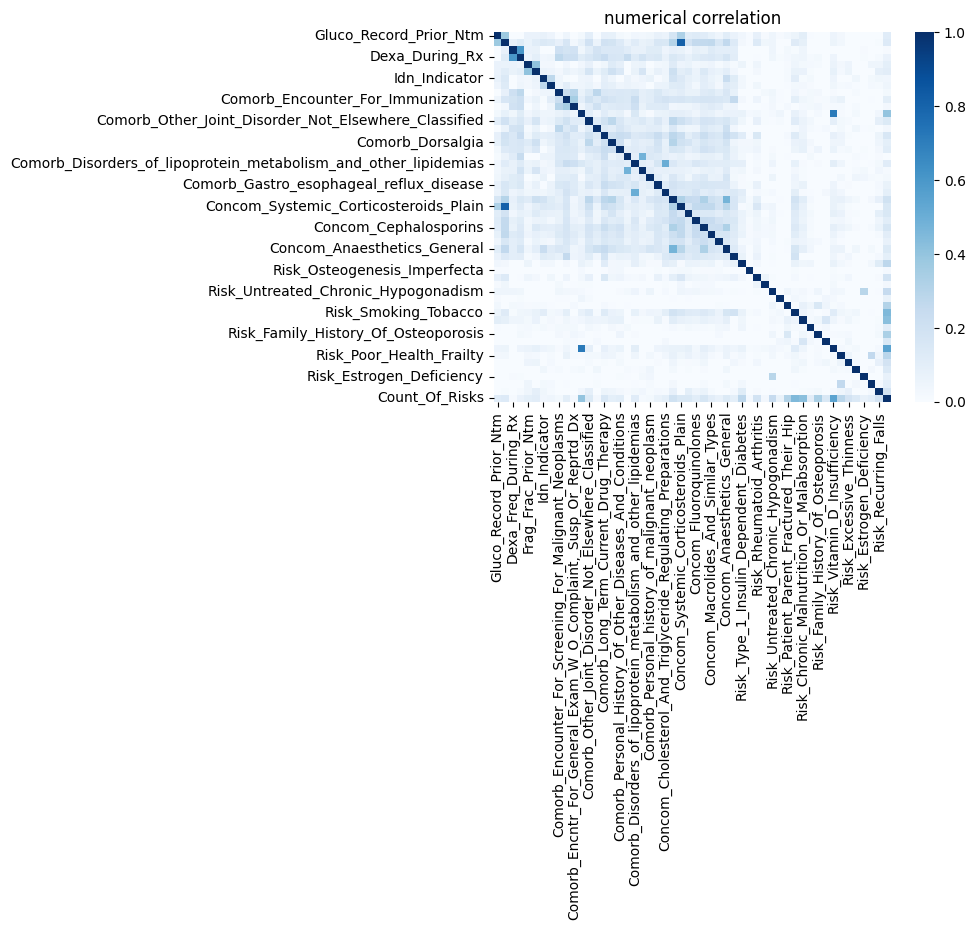

In [21]:
sns.heatmap(data_numerical.corr(),cmap='Blues',vmin=0,vmax=1).set(title='numerical correlation')

In [31]:
gender_persistency = data.groupby(['Gender','Persistency_Flag'])['Persistency_Flag']
gender_persistency.count()

Gender  Persistency_Flag
Female  Non-Persistent      2018
        Persistent          1212
Male    Non-Persistent       117
        Persistent            77
Name: Persistency_Flag, dtype: int64

In [26]:
Ethnicity_persistency = data.groupby(['Ethnicity','Persistency_Flag'])['Persistency_Flag']
Ethnicity_persistency.count()

Ethnicity     Persistency_Flag
Hispanic      Non-Persistent        66
              Persistent            32
Not Hispanic  Non-Persistent      2008
              Persistent          1227
Unknown       Non-Persistent        61
              Persistent            30
Name: Persistency_Flag, dtype: int64

<Axes: xlabel='Persistency_Flag', ylabel='count'>

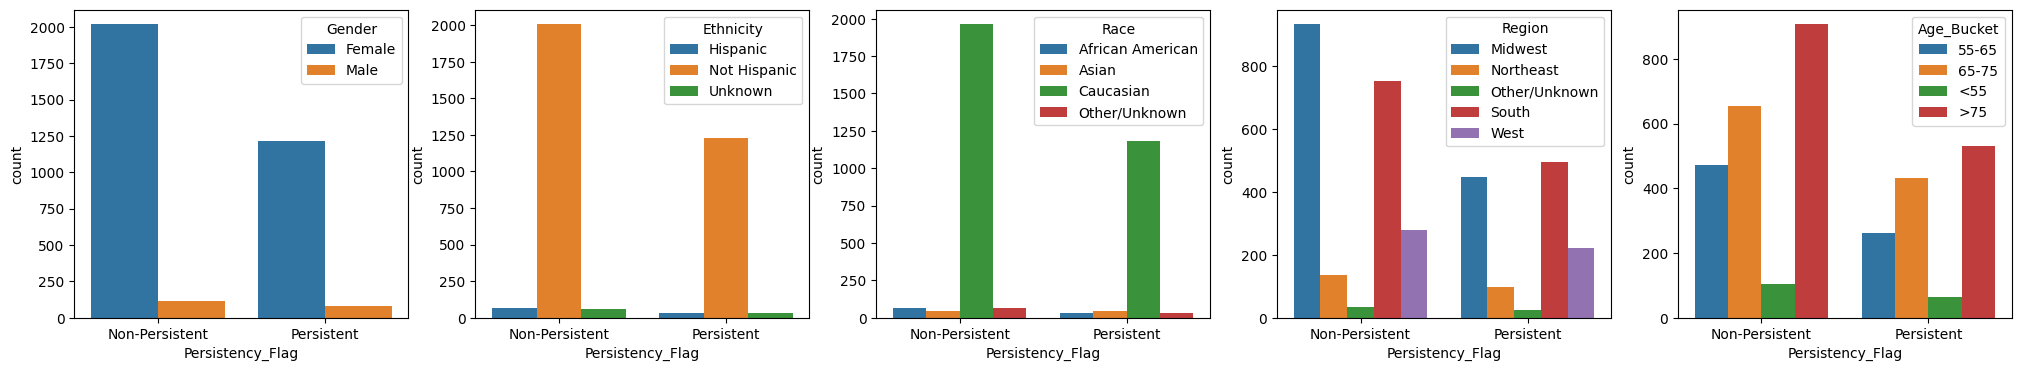

In [56]:
fig, axes = plt.subplots(1, 5, figsize = (25,4),dpi=100)
hist_df = data.groupby(['Gender','Persistency_Flag']).size().to_frame('count').reset_index()
sns.barplot(data=hist_df, x='Persistency_Flag', y='count', hue='Gender', ax=axes[0])

hist_df = data.groupby(['Ethnicity','Persistency_Flag']).size().to_frame('count').reset_index()
sns.barplot(data=hist_df, x='Persistency_Flag', y='count', hue='Ethnicity', ax=axes[1])

hist_df = data.groupby(['Race','Persistency_Flag']).size().to_frame('count').reset_index()
sns.barplot(data=hist_df, x='Persistency_Flag', y='count', hue='Race', ax=axes[2])

hist_df = data.groupby(['Region','Persistency_Flag']).size().to_frame('count').reset_index()
sns.barplot(data=hist_df, x='Persistency_Flag', y='count', hue='Region', ax=axes[3])

hist_df = data.groupby(['Age_Bucket','Persistency_Flag']).size().to_frame('count').reset_index()
sns.barplot(data=hist_df, x='Persistency_Flag', y='count', hue='Age_Bucket', ax=axes[4])